# Kaggle Dataset - heart disease

## Introdução 

O dataset vem com variáveis que poderiam explicar se uma pessoa terá ou não doenças cardiacas.

# Importação de pacotes e carga de dados

### Pacotes 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score,roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score
from numpy import mean
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import sys
import os
os.chdir(r'C:\Users\Thiago Bluhm\OneDrive - Grupo Portfolio\Documentos\ESTUDO\DEEP LEARNING e REDES NEURAIS\tensorflow\dados')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

import warnings
warnings.filterwarnings('ignore')

### Confirmando o uso de GPU

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
# Posicionando o dispositivo de Registro
tf.debugging.set_log_device_placement(True)

In [2]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


### Descarregando a base 

In [3]:
df = pd.read_csv("heart_2020_cleaned.csv", sep=",")

In [4]:
df[:3]

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No


Vamos pegar apenas a raça negra e verificar os dados

In [5]:
def plot_est_random(x, y, z, var1, indice):
    fig = plt.figure(figsize=(20,5))

    ax1 = fig.add_subplot(1,3,1)
    ax2 = fig.add_subplot(1,3,2)
    ax3 = fig.add_subplot(1,3,3)

    ax1.hist(x[var1[indice]], bins=25, color='#3434F6')
    ax2.hist(y[var1[indice]], bins=25, color='#B680DA')
    ax3.hist(z[var1[indice]], bins=25, color='#F04D5C')

    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show()
    
def calculos_est(x,y,z, var1, indice):
    med  = np.mean(x[var1[indice]])
    med1 = np.mean(y[var1[indice]])
    med2 = np.mean(z[var1[indice]])
    
    mediana  = np.median(x[var1[indice]])
    mediana1 = np.median(y[var1[indice]])
    mediana2 = np.median(z[var1[indice]])

    sd  = np.std(x[var1[indice]])
    sd1 = np.std(y[var1[indice]])
    sd2 = np.std(z[var1[indice]])

    print(f'Desvio original {sd}, desvio para amostra 1 = {sd1}, desvio para amostra 2 = {sd2}\n')
    print(f'Media original: {med}, media 1: {med1}, media 2: {med2}\n')
    print(f'Mediana original: {mediana}, mediana 1: {mediana1}, mediana 2: {mediana2}\n')
    print(f'Amostra original: {len(x[var1[indice]])} | Amostra 1: {len(y[var1[indice]])} | Amostra 2: {len(z[var1[indice]])}')

In [6]:
var1 = ['BMI','PhysicalHealth', 'MentalHealth','SleepTime']
var2 = ['White', 'Black']
a = 0
aa = 0

df_tt = df[(df['Race'] == var2[a]) & (df['HeartDisease'] == 'Yes')]

qtd1 = int(len(df_tt) * 0.025)

df_1 = df_tt[df_tt['Race'] == var2[a]].sample(qtd1)
df_2 = df_tt[df_tt['Race'] == var2[a]].sample(qtd1*5)

#### Extratifica sem reposicao

In [7]:
qtd2 = int(len(df_2) * 0.05)
df_12 = df_2[df_2['Race'] == var2[a]].sample(qtd2)
df_22 = df_2[df_2['Race'] == var2[a]].sample(qtd2*5)

In [8]:
calculos_est(df_tt,df_1, df_2, var1, aa)

Desvio original 6.371647180936933, desvio para amostra 1 = 6.3782771641788445, desvio para amostra 2 = 6.39056312888022

Media original: 29.20698404940685, media 1: 29.607935943060493, media 2: 29.271441281138795

Mediana original: 28.25, mediana 1: 28.54, mediana 2: 28.34

Amostra original: 22507 | Amostra 1: 562 | Amostra 2: 2810


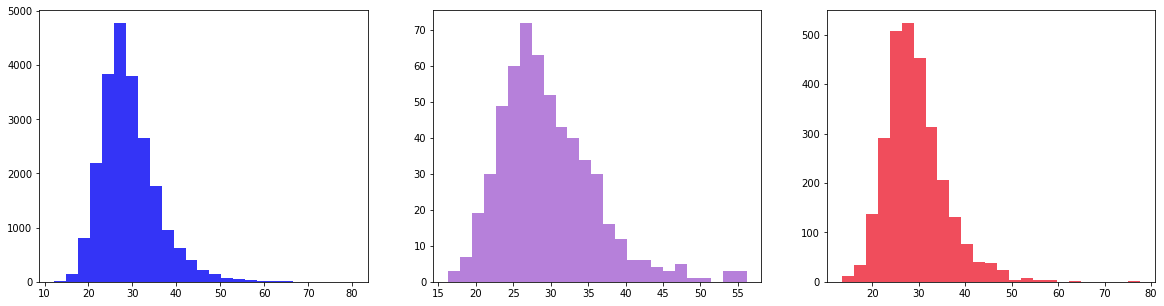

In [9]:
plot_est_random(df_tt,df_1, df_2, var1, aa)

In [10]:
calculos_est(df_2,df_12, df_22, var1, aa)

Desvio original 6.39056312888022, desvio para amostra 1 = 5.988138247691796, desvio para amostra 2 = 6.31814389374291

Media original: 29.271441281138795, media 1: 29.03057142857143, media 2: 29.10077142857143

Mediana original: 28.34, mediana 1: 27.675, mediana 2: 28.19

Amostra original: 2810 | Amostra 1: 140 | Amostra 2: 700


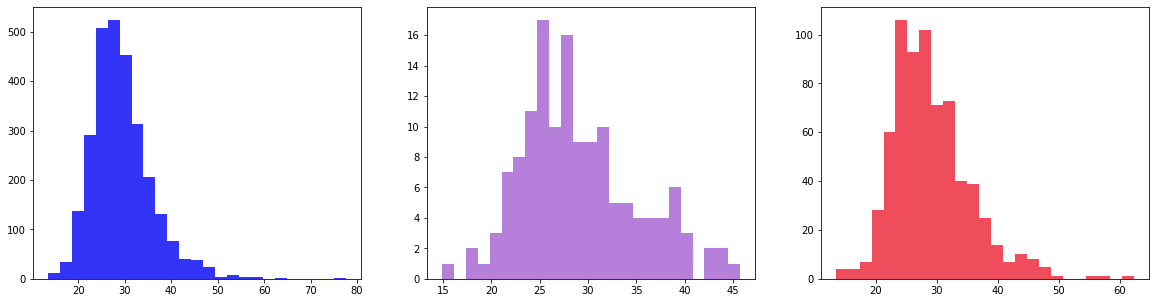

In [11]:
plot_est_random(df_2,df_12, df_22, var1, aa)

#### Modificações nas colunas 

In [12]:
df.GenHealth = [x if x != 'Very good' else 'VeryGood' for x in df.GenHealth]
df.AgeCategory = [x if x != '80 or older' else 'gt80' for x in df.AgeCategory]
df.HeartDisease = [1 if x != 'No' else 0 for x in df.HeartDisease]
df.Diabetic = [x if x != 'Yes (during pregnancy)' else 'ydp' for x in df.Diabetic]

#### Recarregando o Dataset original

In [13]:
df_dc = df[(df['BMI'] > 35) & (df['SleepTime'] > 5)] #hipotese obesos e com pouco sono

In [14]:
x = df_dc['HeartDisease'].value_counts()
print(f'Taxa de pessoas com doenças cardiacas: {round(x[1]/x[0], 2) * 100}%')

Taxa de pessoas com doenças cardiacas: 12.0%


In [15]:
(df_dc.groupby(['Race','Sex','AlcoholDrinking','PhysicalActivity']) \
                             .agg({'HeartDisease':'count', 'BMI':'mean', 'SleepTime':'mean'})).style \
                             .format({"HeartDisease": "{:20,.0f}"}) \
                             .format({"BMI": "{:20,.2f}"}) \
                             .format({"SleepTime": "{:20,.2f} h/dia"}) \
                             .bar(subset=["HeartDisease"], color='#AABB00')

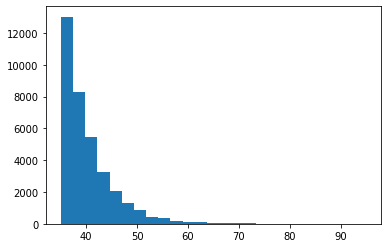

In [16]:
plt.hist(df_dc['BMI'], bins=25)
plt.show()

In [17]:
df_dc.drop(columns='HeartDisease').corr(method='pearson').style.background_gradient(cmap='Blues') \
                                  .applymap(lambda x: f"color: {'red' if x <= 0 else 'black'}")\
                                  .applymap(lambda x: f"color: {'white' if x == 1 else 'black'}")

,BMI,PhysicalHealth,MentalHealth,SleepTime
BMI,1.000000,0.119537,0.089177,0.007166
PhysicalHealth,0.119537,1.000000,0.278843,0.076978
MentalHealth,0.089177,0.278843,1.000000,0.021786
SleepTime,0.007166,0.076978,0.021786,1.000000


#### Describe apenas para numericas 

In [18]:
df_dc.describe(include=[np.number])

,HeartDisease,BMI,PhysicalHealth,MentalHealth,SleepTime
count,35653.000000,35653.000000,35653.000000,35653.000000,35653.000000
mean,0.103638,40.289445,4.841276,4.793005,7.348189
std,0.304794,5.412784,9.244468,8.689768,1.371599
min,0.000000,35.010000,0.000000,0.000000,6.000000
25%,0.000000,36.580000,0.000000,0.000000,6.000000
50%,0.000000,38.650000,0.000000,0.000000,7.000000
75%,0.000000,42.220000,4.000000,5.000000,8.000000
max,1.000000,94.850000,30.000000,30.000000,24.000000


#### Dummyzation 

In [19]:
df_1 = df.copy() #df[(df['BMI'] > 20)  & (df['SleepTime'] < 6)]

In [20]:
#df_1.groupby(['Race','Sex','AlcoholDrinking','PhysicalActivity', 'HeartDisease']).agg({'HeartDisease':'count'})

In [21]:
df_ = pd.get_dummies(df_1, columns=['Smoking', 'AlcoholDrinking', 'Stroke',
       'DiffWalking', 'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth',
       'Asthma', 'KidneyDisease', 'SkinCancer']) 

In [22]:
df_.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 51 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   HeartDisease                         319795 non-null  int64  
 1   BMI                                  319795 non-null  float64
 2   PhysicalHealth                       319795 non-null  float64
 3   MentalHealth                         319795 non-null  float64
 4   SleepTime                            319795 non-null  float64
 5   Smoking_No                           319795 non-null  uint8  
 6   Smoking_Yes                          319795 non-null  uint8  
 7   AlcoholDrinking_No                   319795 non-null  uint8  
 8   AlcoholDrinking_Yes                  319795 non-null  uint8  
 9   Stroke_No                            319795 non-null  uint8  
 10  Stroke_Yes                           319795 non-null  uint8  
 11  DiffWalking_N

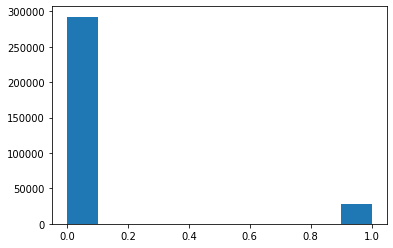

In [24]:
plt.hist(df_.HeartDisease)
plt.show()

In [ ]:
#df_.columns

# Análises nos dados 

### Stats Models para escolher variaveis

In [25]:
import statsmodels.api as sm
from patsy import dmatrices, dmatrix, demo_data

#### Escolha de variáveis 

In [26]:
variaveis = 'HeartDisease ~  BMI + PhysicalHealth + MentalHealth + SleepTime + Smoking_No + \
 AlcoholDrinking_No +  AlcoholDrinking_Yes +  Stroke_No +  Stroke_Yes +  DiffWalking_No +  DiffWalking_Yes + \
 Q("Race_American Indian/Alaskan Native") + Race_White + Race_Asian +  Race_Black +  Race_Hispanic +  Race_Other + \
 Sex_Female +  Sex_Male +  Q("AgeCategory_18-24") +  Q("AgeCategory_25-29") +  Q("AgeCategory_30-34") +  Q("AgeCategory_35-39") + \
 Q("AgeCategory_40-44") +  Q("AgeCategory_45-49") +  Q("AgeCategory_50-54") +  Q("AgeCategory_55-59") +  Q("AgeCategory_60-64") + \
 Q("AgeCategory_65-69") +  Q("AgeCategory_70-74") +  Q("AgeCategory_75-79") +  AgeCategory_gt80 + \
 Diabetic_Yes +  PhysicalActivity_No +  PhysicalActivity_Yes +  GenHealth_Excellent +  GenHealth_Fair + \
 GenHealth_Poor +  GenHealth_VeryGood +  Asthma_No +  Asthma_Yes +  KidneyDisease_No +  KidneyDisease_Yes + \
 SkinCancer_No +  SkinCancer_Yes'


# Q("Race_American Indian/Alaskan Native") + \  Race_Asian +  Race_Black +  Race_Hispanic +  Race_Other + 

#### Avaliando os Betas 

In [27]:
y_treino, X_treino = dmatrices(variaveis, 
                 data=df_, return_type='dataframe')

In [28]:
X_treino.exog = sm.add_constant(X_treino)
logit_mod = sm.GLM(y_treino, X_treino, family=sm.families.Binomial())
logit_res = logit_mod.fit()
print(logit_res.summary2())

                            Results: Generalized linear model
Model:                       GLM                     AIC:                   145232.2431  
Link Function:               Logit                   BIC:                   -3907924.3192
Dependent Variable:          HeartDisease            Log-Likelihood:        -72580.      
Date:                        2022-06-04 10:14        LL-Null:               -93453.      
No. Observations:            319795                  Deviance:              1.4516e+05   
Df Model:                    35                      Pearson chi2:          3.04e+05     
Df Residuals:                319759                  Scale:                 1.0000       
Method:                      IRLS                                                        
-----------------------------------------------------------------------------------------
                                          Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------

### Definindo o dataset final

In [ ]:
#X_treino.columns

#### Definindo variáveis explicativas 

In [29]:
data = df_.loc[:, ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime',
       'Smoking_No', 'AlcoholDrinking_No', 'AlcoholDrinking_Yes', 'Stroke_No',
       'Stroke_Yes', 'DiffWalking_No', 'DiffWalking_Yes', 'Sex_Female',
       'Sex_Male', 'AgeCategory_18-24', 'AgeCategory_25-29',
       'AgeCategory_30-34', 'AgeCategory_35-39', 'Race_American Indian/Alaskan Native', 'Race_Asian', 'Race_Black',
       'Race_Hispanic', 'Race_Other', 'Race_White', 
       'AgeCategory_40-44', 'AgeCategory_45-49',
       'AgeCategory_50-54', 'AgeCategory_55-59',
       'AgeCategory_60-64', 'AgeCategory_65-69',
       'AgeCategory_70-74', 'AgeCategory_75-79', 'AgeCategory_gt80',
       'Diabetic_Yes',
       'PhysicalActivity_No', 'PhysicalActivity_Yes', 'GenHealth_Excellent',
       'GenHealth_Fair', 'GenHealth_Poor', 'GenHealth_VeryGood', 'Asthma_No',
       'Asthma_Yes', 'KidneyDisease_No', 'KidneyDisease_Yes', 'SkinCancer_No',
       'SkinCancer_Yes']]

# 'Race_American Indian/Alaskan Native', 'Race_Asian', 'Race_Black',
# 'Race_Hispanic', 'Race_Other', 'Race_White', 

#### Definindo variável alvo 

In [30]:
target = df_['HeartDisease']

#### Transformando em arrays numpy 

In [31]:
data = np.asarray(data)
target = np.asarray(target)

#### Split em treino, teste e validacao

In [32]:
X_train_full, X_test, y_train_full, y_test = train_test_split(data, target,  random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

#### Padronização de valores  

In [33]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

# O modelo e hiperparâmetros

### Definindo as camadas de entrada e ocultas 

#### Definição da funcao de ativacao Sigmoid e o build com o shape na entrada

In [34]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=X_train.shape[1:]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(50, activation="relu", name="oculta1"),
    keras.layers.Dense(50, activation="relu", name="oculta2"),
    keras.layers.Dense(50, activation="relu", name="oculta3"),
    keras.layers.Dense(1, activation="sigmoid")
])

In [35]:
"""kl = keras.layers
input_ = kl.Input(shape=X_train.shape[1:]) #qtd vars
hidden1 = kl.Dense(30, activation="relu")(input_)
hidden2 = kl.Dense(30, activation="relu")(hidden1)
hidden3 = kl.Dense(30, activation="relu")(hidden2)
hidden4 = kl.Dense(30, activation="relu")(hidden3)
concat = kl.Concatenate()([input_, hidden4])
output = kl.Dense(1)(concat)
model = keras.Model(inputs=[input_], outputs=[output])"""

'kl = keras.layers\ninput_ = kl.Input(shape=X_train.shape[1:]) #qtd vars\nhidden1 = kl.Dense(30, activation="relu")(input_)\nhidden2 = kl.Dense(30, activation="relu")(hidden1)\nhidden3 = kl.Dense(30, activation="relu")(hidden2)\nhidden4 = kl.Dense(30, activation="relu")(hidden3)\nconcat = kl.Concatenate()([input_, hidden4])\noutput = kl.Dense(1)(concat)\nmodel = keras.Model(inputs=[input_], outputs=[output])'

#### Criando metricas para a regressao logit e definição de Cutoff

In [36]:
tf.keras.metrics.FalseNegatives?

In [37]:
tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", threshold=0.2
)

tf.keras.metrics.FalseNegatives(
    name="false_negatives", thresholds=0.2    
)

#### Compilando o modelo 

In [ ]:
model.compile?

In [38]:
model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              metrics=[tf.keras.metrics.BinaryAccuracy(), 
                       tf.keras.metrics.FalseNegatives()])

#### Definição do diretorio do tensorboard

In [39]:
root_logdir = os.path.join(os.curdir, "my_logs_hd")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

root_logdir = get_run_logdir()

#### Funções Callback para parada acidental, parada com loss sem alteracao, gravação no tensorboard

In [40]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("modelo5_heart_disease.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
tensorboad_cb = keras.callbacks.TensorBoard(root_logdir)

#### Fitando o modelo 

In [41]:
hist = model.fit(X_train, y_train, 
                     epochs=100, batch_size = 10, verbose = 2,
                     callbacks=[checkpoint_cb,early_stopping_cb, tensorboad_cb],
                     validation_data=(X_valid, y_valid))

Epoch 1/100
17989/17989 - 231s - loss: 0.2293 - binary_accuracy: 0.9156 - false_negatives: 14479.0000 - val_loss: 0.2267 - val_binary_accuracy: 0.9162 - val_false_negatives: 4831.0000 - 231s/epoch - 13ms/step
Epoch 2/100
17989/17989 - 226s - loss: 0.2257 - binary_accuracy: 0.9162 - false_negatives: 14229.0000 - val_loss: 0.2259 - val_binary_accuracy: 0.9162 - val_false_negatives: 4729.0000 - 226s/epoch - 13ms/step
Epoch 3/100
17989/17989 - 226s - loss: 0.2246 - binary_accuracy: 0.9167 - false_negatives: 14116.0000 - val_loss: 0.2279 - val_binary_accuracy: 0.9156 - val_false_negatives: 4477.0000 - 226s/epoch - 13ms/step
Epoch 4/100
17989/17989 - 223s - loss: 0.2241 - binary_accuracy: 0.9167 - false_negatives: 14044.0000 - val_loss: 0.2296 - val_binary_accuracy: 0.9158 - val_false_negatives: 5004.0000 - 223s/epoch - 12ms/step
Epoch 5/100
17989/17989 - 249s - loss: 0.2235 - binary_accuracy: 0.9165 - false_negatives: 14092.0000 - val_loss: 0.2253 - val_binary_accuracy: 0.9166 - val_false_n

#### Salvando o modelo 

In [42]:
model.save("modelo1000n_FN_black_heart_disease_04062022.h5")

#### Verificando o desempenho com a base Teste 

In [43]:
mse_test = model.evaluate(X_test, y_test)

2499/2499 [==============================] - 21s 8ms/step - loss: 0.2299 - binary_accuracy: 0.9143 - false_negatives: 6597.0000


#### Predição 

In [44]:
y_pred = model.predict(X_test)
#y_pred_cl =np.argmax(y_pred,axis=1)
#len(y_pred_cl)


2499/2499 [==============================] - 8s 3ms/step


In [48]:
m = tf.keras.metrics.binary_accuracy(y_test[:100], y_pred[:100], threshold=0.5)
print("Which predictions match with binary labels:", m.numpy())

Which predictions match with binary labels: [0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9
 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.1 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9
 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9
 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.1 0.9 0.9 0.9
 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9
 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]


In [47]:
mm = tf.keras.metrics.BinaryAccuracy()
mm.update_state(y_test, y_pred)
mm.result().numpy()

0.91433287

##### Plotagem do que foi predito 

In [50]:
media = np.mean(y_pred)
mediana = np.median(y_pred)
std = np.std(y_pred)
minimo = np.amin(y_pred)
maximo = np.amax(y_pred)
print(f'Media: {media}, Mediana: {mediana}, Desvio Padrão: {std}, Valor mín.: {minimo}, Valor máx.: {maximo}')

Media: 0.08889030665159225, Mediana: 0.042795076966285706, Desvio Padrão: 0.11026034504175186, Valor mín.: 0.0006828454206697643, Valor máx.: 0.8272997140884399


### Evaluation do modelo

#### Regulando o Cutoff manualmente 

In [51]:
ypred = model.predict(X_test, verbose=1)
ypred = np.argmax(ypred, axis=1)

2499/2499 [==============================] - 8s 3ms/step


In [ ]:
unique, counts = np.unique(ypred, return_counts=True)
np.asarray((unique, counts)).T

In [53]:
ctf = 0.5
y_pred_clm = [1 if x > ctf else 0 for x in y_pred]

#### Jaccard teste para acuracia por classe 

In [55]:
from sklearn.metrics import jaccard_score
jac_1 = jaccard_score(y_test, y_pred_clm, pos_label=1)
jac_0 = jaccard_score(y_test, y_pred_clm, pos_label=0)

print(jac_1, jac_0)

0.04835348061692372 0.913958367357194


#### Matriz de confusão 

In [57]:
CM = confusion_matrix(y_test, y_pred_clm, labels=[0,1]) # 1,0 falso neg em cima / 0,1 falso neg embaixo

Matriz de Confusão, sem normalização
[[72752   252]
 [ 6597   348]]


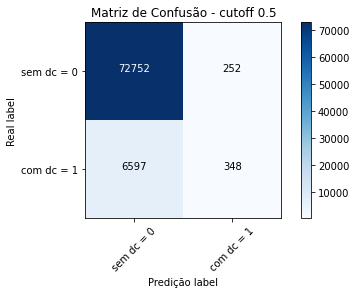

In [60]:
plot_confusion_matrix(CM, classes=['sem dc = 0','com dc = 1'], normalize= False,  title='Matriz de Confusão - cutoff %s' %ctf)

#### Sensitividade e Especificidade

In [61]:
tp,fn,fp,tn= CM[0][0],CM[0][1],CM[1][0],CM[1][1]
sensitividade = (tp / (fp + tp)) * 100
print(f'Nossa sensitividade é de {round(sensitividade,5)} %') # balanco de positivo
especificidade = (tn / (fp + tn)) * 100
print(f'Nossa especificidade é de {round(especificidade,6)} %') # balanco de negativo

Nossa sensitividade é de 91.6861 %
Nossa especificidade é de 5.010799 %


#### Sumário de classificação 

In [62]:
print (classification_report(y_test, y_pred_clm))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     73004
           1       0.58      0.05      0.09      6945

    accuracy                           0.91     79949
   macro avg       0.75      0.52      0.52     79949
weighted avg       0.89      0.91      0.88     79949



#### Curva ROC

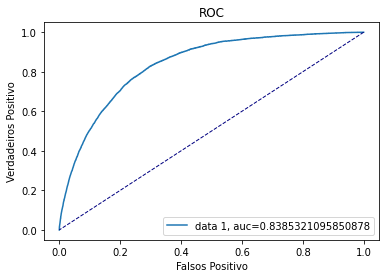

In [63]:
fpr, tpr, _ = roc_curve(y_test,  y_pred, pos_label=1)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.plot([1,0], [1,0], color='navy', lw=1, linestyle='--')
plt.xlabel('Falsos Positivo')
plt.ylabel('Verdadeiros Positivo')
plt.title('ROC')
plt.legend(loc="best")
plt.show()

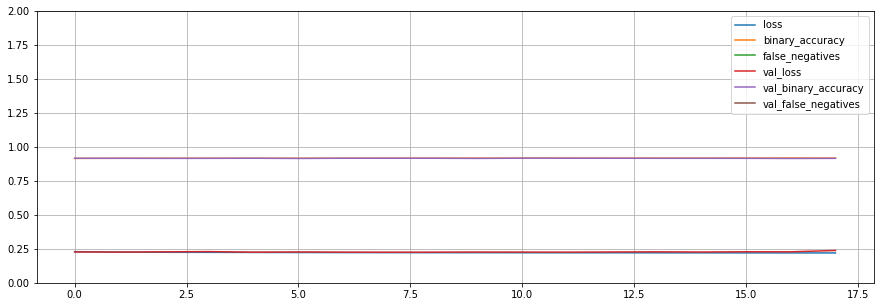

In [64]:
pd.DataFrame(hist.history).plot(figsize=(15,5))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

# Considerações finais

### Carregando o melhor modelo  

In [65]:
model_bes = keras.models.load_model("modelo1_heart_disease.h5") 

# Funções auxiliares

## Matriz de confusão 

In [59]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de Confusão',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalizada Matriz de Confusão")
    else:
        print('Matriz de Confusão, sem normalização')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    
    plt.tight_layout()
    plt.ylabel('Real label')
    plt.xlabel('Predição label')